In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import statsmodels.api as sm

import warnings
warnings.filterwarnings(action = 'ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Data Collection 

<hr>

## Importing Data
The below few code blocks go through the process of extracting the data from WRDS. We have commented out the cells that pull new data from WRDS and instead will read in the data from a csv file for convienence. But by uncommenting the WRDS connection cells, you can retrieve updated data.

Data source: [https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/quarterly-update/mutual-funds/fund-summary/](https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/quarterly-update/mutual-funds/fund-summary/)

In [2]:
# import wrds
# db = wrds.Connection()
# # Enter your credentials.
# # Username: <brandonpover>
# # Password: <DingoDango2865>
# # db.close()

**Extract Small-Cap Value Funds' tickers from (crsp_fund_summary)**

Small-Cap value funds are designate by lipper_class "SCVE"

In [3]:
# fund_summary = db.raw_sql("""SELECT caldt, crsp_fundno, ticker, fund_name, lipper_class_name from crsp.fund_summary2 
#                           WHERE lipper_class = 'SCVE'""", date_cols=['caldt'])

**Extract Monthly Return and Monthly Total Net Asset for All Funds from (crsp_q_mutualfunds)**

The summary table above only has quarterly info, we snag the monthly returns and total fund assets from the following two databases, then join everything together in one happy dataframe. 

In [4]:
# fund_return = db.raw_sql('select caldt, crsp_fundno, mret from crsp_q_mutualfunds.monthly_returns;', 
#                          date_cols=['caldt'])
# fund_tna = db.raw_sql('select caldt, crsp_fundno, mtna from crsp_q_mutualfunds.monthly_tna;', 
#                          date_cols=['caldt'])

# ret_tna = pd.merge(fund_return, fund_tna, left_on = ['caldt','crsp_fundno'], right_on = ['caldt','crsp_fundno'])

# df = fund_summary.merge(ret_tna, how='left',on=['crsp_fundno'])
# df = df.drop(columns=['caldt_x']).rename(columns={"caldt_y": "caldt"})
# df.to_csv("cleaned_monthly_small_value_funds.csv", encoding='utf-8')



## End of WRDS access
<hr>

## Read in data and do some brief cleaning:

### 

In [5]:
df = pd.read_csv('cleaned_monthly_small_value_funds.csv')
df = df.drop(columns=['Unnamed: 0', 'lipper_class_name'])
df.columns = ['fund_num','ticker','fund_name','date','monthly_return','aum']

### Date Prepocessing:
* Drop rows with that were either missing values for the returns field or the total assets.
* Filter out funds that do not have an AUM of at least $1,000,000 and that have not been around for 12 months.
* We remove data from before 1975, as the data was extremely messy and we believe contained errors.


In [6]:
# Drop NaNs for the return and total net asset columns
# df2 = df.dropna(subset = ['monthly_return','aum'])

# UnComment out below three lines and comment above if we just decide to interpolate AUMs.

df2 = df.dropna(subset = ['monthly_return']) # Drop nas for monthly returns
df2['aum'] = df2['aum'].replace(to_replace=0,value=np.nan) # Change 0s to na values so that the below line fixes those too
df2['aum'] = df2.aum.interpolate() # Fill in missing AUMs with the average of the closest two dates. 

df2['date'] = pd.to_datetime(df2['date'])# Convert date to pd datetime
df2 = df2[df2['date'].dt.year >= 1975] # Remove periods before 1975

df2 = df2.drop_duplicates(subset=['fund_num','date']) # Drop weird duplicates


# Only look at funds that have been around for more than a year and average total net asset exceeds 1 million
periods_d = df2.groupby('fund_num')[['aum']].agg(['mean', 'count'])
periods_d.columns = ['avg_aum','period_count']
df2 = df2.merge(periods_d,left_on='fund_num',right_on='fund_num')
df2 = df2[(df2.period_count >=12) & (df2.avg_aum >=1)].copy()



# Add on a column for annualized returns
df2['annualized_return'] = df2['monthly_return'] * 12
df2.head(2)

,fund_num,ticker,fund_name,date,monthly_return,aum,avg_aum,period_count,annualized_return
0,292.00000,CFSVX,CitiFunds Trust II: CitiFunds Small Cap Value ...,1998-04-30,-0.00385,55.46200,24.55297,29,-0.04624
1,292.00000,CFSVX,CitiFunds Trust II: CitiFunds Small Cap Value ...,1998-05-29,-0.05996,55.57500,24.55297,29,-0.71954


<hr>

## Data Exploration:

### Scatterplot:
Can we see anything by examining a scatterplot of AUM and returns for all funds across all time periods?

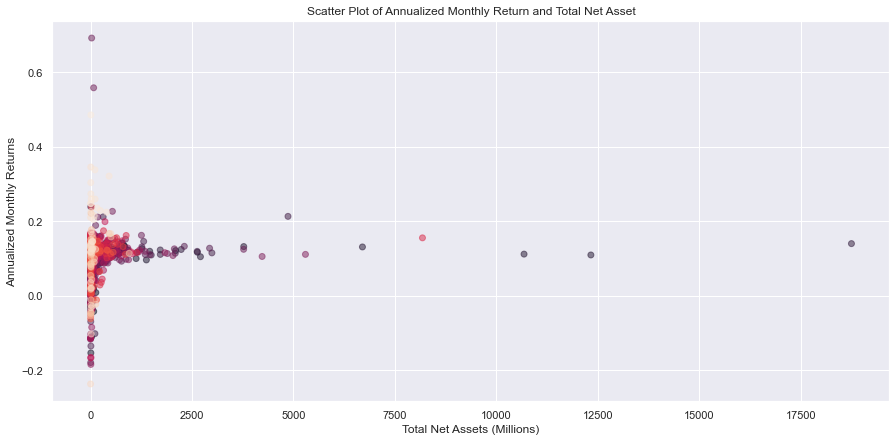

In [7]:
avg_groupby_fund = df2[['fund_num','annualized_return','aum']].groupby('fund_num').mean()
avg_groupby_fund = avg_groupby_fund[avg_groupby_fund['annualized_return'] < 12] #remove an outlier

fig, (ax) = plt.subplots(nrows = 1, ncols = 1, figsize = (15,7))

ax.scatter(avg_groupby_fund['aum'], avg_groupby_fund['annualized_return'], c=avg_groupby_fund.index, alpha=0.5)
ax.set_title('Scatter Plot of Annualized Monthly Return and Total Net Asset')
ax.set_xlabel('Total Net Assets (Millions)')
ax.set_ylabel('Annualized Monthly Returns')
plt.show()

Not really, there's a lot of noise there. One interesting note here is how the variance of fund performance tends to decrease with asset size. Likely because of diversification.

## Cumulative Returns

**Classify by fund size**

We decide to separate each fund into a 3 size categories: small, medium, and large. We make this classification by looking at all of the funds on a particular date and divide the funds into the three categories based on AUM at that date. We do this grouping by each date because we feel the most relevant grouping for this funds is on an inter-period basis. 

In [1]:
df_classes = pd.DataFrame()
date_list = df2[['date']].drop_duplicates().sort_values(by = 'date') # Unique series of dates 
size_labels= ['Small', 'Medium', 'Large']

# Below loop goes through all of the dates and  creates bins for each fund based on its relative position amongst funds of that same date
for date in date_list['date']:
    filtered_df = df2[df2['date'] == date] # Filter df by that date
    filtered_df['class'] = pd.cut(filtered_df.aum.rank(pct=True), len(size_labels), labels=size_labels) # Get bins for aums for that date
    df_classes = pd.concat([df_classes, filtered_df], axis=0) # Concat them into our master data frame

df_classes.head(2)

NameError: name 'pd' is not defined

For each date, get the average return for that fund size:

In [9]:
avg_returns_by_class = df_classes.groupby(['date','class'])[['monthly_return']].mean().unstack('class')
avg_returns_by_class.head(3)

monthly_return                
class               Small  Medium   Large
date                                     
1975-01-31        0.22824 0.01814 0.07196
1975-02-28        0.12347 0.02339 0.05124
1975-03-31        0.04683 0.05114 0.01459

Now we can examine the cumulative returns of each fund size by examining how an investment in an average fund would turn out for each category: 

Text(0, 0.5, 'Dollars')

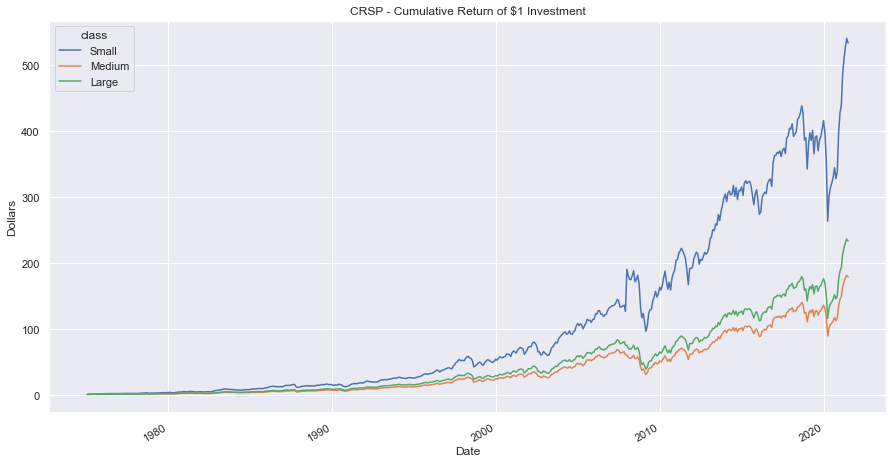

In [10]:
cumulative_retuns = (avg_returns_by_class+1).cumprod()['monthly_return']
cumulative_retuns.plot(figsize=(15,8))

plt.title('CRSP - Cumulative Return of $1 Investment')
plt.xlabel('Date')
plt.ylabel('Dollars')

In [11]:
small_minus_big = cumulative_retuns.Small.iloc[-1] - cumulative_retuns.Large.iloc[-1]

print(f'$1 consistently invested in the average small fund from 1975 to 2021 (as of June) would generate an additional ${small_minus_big:.2f} in \
 gains relative to the amount gained by investing $1 in the average large fund.')

$1 consistently invested in the average small fund from 1975 to 2021 (as of June) would generate an additional $300.08 in  gains relative to the amount gained by investing $1 in the average large fund.


Base on the above results, it appears that investing in smaller funds will lead to higher long-term returns.

<hr>

## Summary Statistics:

But we know that simply looking at cumulative returns is an incomplete measure of fund success so let's examine the data in further detail, with the goal of examining not only returns, but risk as well:

In [12]:
df_classes.groupby('class')['monthly_return'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
Small,64739.00000,0.01045,0.43534,-0.87716,-0.01980,0.01338,0.04114,109.78472
Medium,63030.00000,0.00906,0.06821,-0.87779,-0.01967,0.01363,0.04116,9.31267
Large,63231.00000,0.00922,0.05589,-0.35351,-0.01859,0.01388,0.04067,2.13493


Again we note that smaller funds do have higher average performance, but of note here is their standard deviation, is substantially higher than both medium and larger funds. This is an important consideration to keep in mind because although the average small cap fund may perform better, the dispersion of those results is much higher than larger funds and if you choose the wrong fund in the wrong period, your performance may be dramatically different than the average.

<br>

That being said, we do not believe that the standard deviation is the best measure of risk for this analysis. Standard deviation is substantially influenced by outliers and as the above table depicts, smaller funds are penalized for their extreme positive outliers, such as the maximum return of 10,900% for one month. This value may be a data error or it could be legitimate. Regardless, we have decided to use the mean absolute deviation as our measure for risk as it is var less sensitive to extreme values. In the below output displaying the MADS for each fund size, you can see that the MAD is still higher for smaller funds, but the change is not so dramatic.

In [13]:
df_classes.groupby('class')['monthly_return'].mad()

class
Small    0.04310
Medium   0.04119
Large    0.03999
Name: monthly_return, dtype: float64

## Bar Plots Depicting Summary Statistics: Means, MAD, and Sharpe Ratio (MAD version)

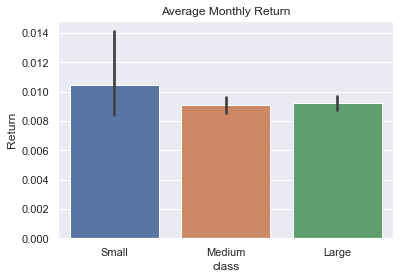

In [14]:
sns.barplot(data=df_classes,x='class',y='monthly_return')
plt.title('Average Monthly Return')
plt.ylabel('Return');

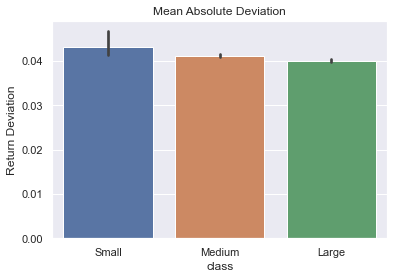

In [15]:
from numpy import mean, absolute
def my_mad(data, axis=None):
    return mean(absolute(data - mean(data, axis)), axis)

sns.barplot(data=df_classes,x='class',y='monthly_return',estimator=my_mad)
plt.title('Mean Absolute Deviation');
plt.ylabel('Return Deviation');

#### Return per unit of risk:
Below we depict our adjusted sharpe ratio for each fund size where our sharpe ratio is calculated as the mean return divided by the MAD. 

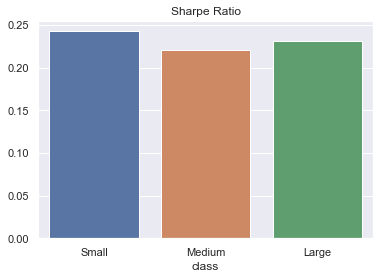

In [16]:
temp = (df_classes.groupby('class')[['monthly_return']].mean()/df_classes.groupby('class')[['monthly_return']].mad()).reset_index()
sns.barplot(data=temp, y='monthly_return',x='class')
plt.ylabel('')
plt.title('Sharpe Ratio');

It looks like the smaller funds continue to dominate, even when adjusting performance for risk.

<hr>

## Regression

To add some statistical rigor to the analysis, we perform a regression based on the following equation:

$$ MonthlyReturn_i = \beta_0 + Small_i*\beta_1 + Medium_i*\beta_2$$ 

Add on dummy variables to indicate fund size:

In [17]:
one_hot = pd.get_dummies(df_classes['class'])
df_regression= df_classes.join(one_hot)
df_regression.head(2)

,fund_num,ticker,fund_name,date,monthly_return,aum,avg_aum,period_count,annualized_return,class,Small,Medium,Large
24296,8124.00000,WFAGX,DLJ Winthrop Focus Funds: DLJ Winthrop Small C...,1975-01-31,0.08654,15.50100,97.51740,457,1.03846,Large,0,0,1
49067,10960.00000,FPPTX,"FPA Capital Fund, Inc",1975-01-31,0.05738,46.36100,563.49400,553,0.68852,Large,0,0,1


In [18]:
X = df_regression[['Small','Medium']]
y = df_regression['monthly_return']

X = sm.add_constant(X)
model = sm.OLS(y,X)

result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         monthly_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5571
Date:                Sun, 17 Oct 2021   Prob (F-statistic):              0.573
Time:                        13:55:34   Log-Likelihood:                -12597.
No. Observations:              191000   AIC:                         2.520e+04
Df Residuals:                  190997   BIC:                         2.523e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0092      0.001      8.969      0.0

The results above do not lend much support to the small-fund premium hypothesis. Neither the small-fund nor the medium-fund coefficients are significant at the 5% threshold. While the small-fund result does exhibity a positive coefficient, the variability mean we cannot state this result is not simply due to chance or noise in the data. 

# Inter-Temporal Size Affect

Before, we were looking at each individual monthly return as a distinct, independent unit, but we would now like to analyze funds by exploring if a fund's performance changes when its returns are categorized into two relative sizes based on the fund's AUM across its life. That will allow us to compare the average return of the fund when it was 'larger' vs the average return when the fund was 'smaller'. We can then aggregate those numbers across all funds to understand the big picture:

Because we are trying to compare a fund's performance when it was smaller vs larger, we only consider funds where the AUM has changed by a certain threshold. It would not make sense to classify a fund into 'smaller' and 'bigger' if the AUM in 'bigger' was only marginally bigger than the AUM of 'smaller'. In this case, we only examine funds that have had a maximum AUM of 500% greater than the minimum AUM.

Below, we get each fund's 'growth multiple' which is simply the funds (maximum AUM/ Minimum AUM). Afterwards we filter our all funds that have not changed by the chosen threshold.

In [19]:
def get_fund_growth_multiple(series:pd.Series):
    return series.max()/series.min()

In [20]:
growth_multiples = df_classes.groupby('fund_num')[['aum']].aggregate(get_fund_growth_multiple)
growth_multiples.columns = ['growth_multiples']
growth_multiples.head(2)

,growth_multiples
fund_num,
292.00000,9.58190
479.00000,4.31917


In [21]:
growth_threshold = 6

df_multiples = df_classes.merge(growth_multiples,left_on='fund_num',right_on='fund_num')
df_growers = df_multiples[df_multiples.growth_multiples >= growth_threshold] # Grown by at least 500%%
df_growers.head(2)

,fund_num,ticker,fund_name,date,monthly_return,aum,avg_aum,period_count,annualized_return,class,growth_multiples
0,8124.00000,WFAGX,DLJ Winthrop Focus Funds: DLJ Winthrop Small C...,1975-01-31,0.08654,15.50100,97.51740,457,1.03846,Large,28.04277
1,8124.00000,WFAGX,DLJ Winthrop Focus Funds: DLJ Winthrop Small C...,1975-02-28,0.05752,17.71800,97.51740,457,0.69027,Large,28.04277


Below, we create the approporiate segments for each fund: Group by each fund and segment the returns into 'smaller' or 'bigger'.

In [22]:
aggregated_df:pd.DataFrame = pd.DataFrame() # Master dataframe that will be populated in the below for loop.

group_by_name = df_growers.groupby('fund_num')
group_size_labels = ['smaller','bigger']

for name, group in group_by_name:
    group['inter_temporal_size'] = pd.cut(group.aum,bins=len(group_size_labels), labels=group_size_labels)
    aggregated_df = pd.concat([aggregated_df,group])

aggregated_df.head(2)

,fund_num,ticker,fund_name,date,monthly_return,aum,avg_aum,period_count,annualized_return,class,growth_multiples,inter_temporal_size
71992,292.00000,CFSVX,CitiFunds Trust II: CitiFunds Small Cap Value ...,1998-04-30,-0.00385,55.46200,24.55297,29,-0.04624,Medium,9.58190,bigger
71993,292.00000,CFSVX,CitiFunds Trust II: CitiFunds Small Cap Value ...,1998-05-29,-0.05996,55.57500,24.55297,29,-0.71954,Medium,9.58190,bigger


## Results: 

In [23]:
df3 = aggregated_df.groupby(['fund_num','inter_temporal_size'])['monthly_return'].mean().unstack()
df3.columns = ['smaller','bigger']
df3['small_minus_big'] = df3.smaller - df3.bigger
df3['small_is_better'] = df3['smaller'] > df3['bigger']
df3.head(3)

,smaller,bigger,small_minus_big,small_is_better
fund_num,,,,
292.00000,0.00218,-0.03436,0.03654,True
657.00000,0.01892,-0.00704,0.02596,True
709.00000,0.01114,0.00842,0.00272,True


On average, funds have a higher average return when they are smaller is greater than when they are bigger:

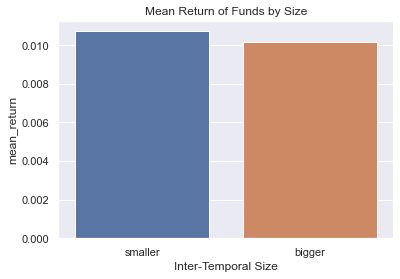

In [24]:
summary_stats = df3[['smaller','bigger']].mean()
summary_stats = pd.DataFrame(summary_stats,columns=['mean_return']).reset_index()
sns.barplot(data=summary_stats,x='index',y='mean_return')
plt.title('Mean Return of Funds by Size')
plt.xlabel('Inter-Temporal Size');

But, a higher number of funds do have higher average returns when they are larger:

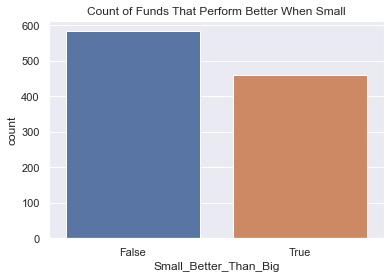

In [25]:
sns.countplot(data=df3,x='small_is_better')
plt.title('Count of Funds That Perform Better When Small')
plt.xlabel('Small_Better_Than_Big');